In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os


In [34]:



file_path_1 = '/Users/aa/Desktop/hdb_cooling_analysis/data/raw/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv'
file_path_2 = '/Users/aa/Desktop/hdb_cooling_analysis/data/raw/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv'


df_1 = pd.read_csv(file_path_1)
df_2 = pd.read_csv(file_path_2)

#Merging of frames

combined_data = pd.concat([df_1, df_2], sort = False)

combined_data['month'] =pd.to_datetime(combined_data['month'])
combined_data['floor_area_sqm'] = pd.to_numeric(combined_data['floor_area_sqm'], errors = 'coerce')

combined_data['treatment_group'] = combined_data['flat_type'].isin(['5 ROOM', 'EXECUTIVE']).astype(int)

combined_data['price_psf'] = combined_data['resale_price'] / (combined_data['floor_area_sqm'] * 10.764)

combined_data['price_psf_rounded'] = combined_data['price_psf'].round(2)

combined_data['post_policy'] = (combined_data['month'] >= '2013-01-01').astype(int)

display(combined_data)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,treatment_group,price_psf,price_psf_rounded,post_policy
0,2012-03-01,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0,NaN,0,516.123705,516.12,0
1,2012-03-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0,NaN,0,559.525016,559.53,0
2,2012-03-01,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0,NaN,0,430.356089,430.36,0
3,2012-03-01,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0,NaN,0,443.712319,443.71,0
4,2012-03-01,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0,NaN,0,445.098920,445.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37148,2016-12-01,YISHUN,5 ROOM,297,YISHUN ST 20,13 TO 15,112.0,Improved,2000,488000.0,82.0,1,404.788448,404.79,1
37149,2016-12-01,YISHUN,5 ROOM,838,YISHUN ST 81,01 TO 03,122.0,Improved,1987,455000.0,69.0,1,346.479766,346.48,1
37150,2016-12-01,YISHUN,EXECUTIVE,664,YISHUN AVE 4,10 TO 12,181.0,Apartment,1992,778000.0,74.0,1,399.325766,399.33,1
37151,2016-12-01,YISHUN,EXECUTIVE,325,YISHUN CTRL,01 TO 03,146.0,Maisonette,1988,575000.0,70.0,1,365.882215,365.88,1


In [35]:
%matplotlib inline
time_series = combined_data.groupby(['month', 'treatment_group'])['price_psf'].mean().reset_index()

treatment_data = time_series[time_series['treatment_group'] ==1]
control_data = time_series[time_series['treatment_group'] ==0]

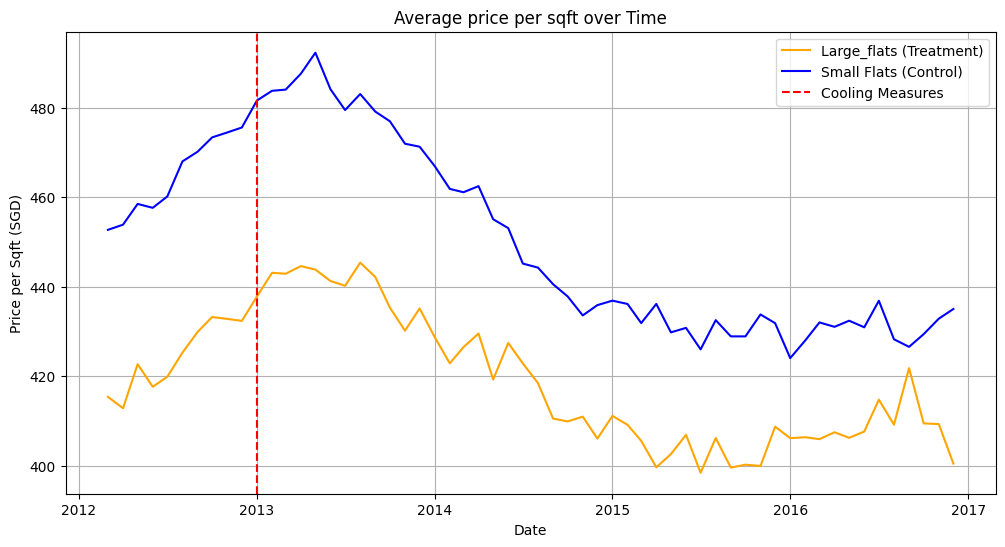

In [36]:
plt.figure(figsize = (12,6))
plt.plot(treatment_data['month'], treatment_data['price_psf'], label = 'Large_flats (Treatment)', color = 'orange')
plt.plot(control_data['month'], control_data['price_psf'], label = 'Small Flats (Control)', color = 'blue')
plt.axvline(pd.Timestamp('2013-01'), color='red', linestyle='--', label='Cooling Measures')
plt.title('Average price per sqft over Time')
plt.xlabel('Date')
plt.ylabel('Price per Sqft (SGD)')
plt.legend()
plt.grid(True)
plt.show()

From a visual glance, the data presents a more complete story. It's self evident from the graph that HDB prices, on a psf basis decreased
following the implementation of the 2013 cooling measures. Not only that, but it's clear that the impact was for the long-term, as prices never reached such highs again for a duration of 4 years. Let's analyse the impact of this on the regression analysis. 

In [39]:
import statsmodels.formula.api as smf

#Exactly the same model as earlier
#Dependent variable: price_psf
#Independent variables: post_policy, treatment_group
#Interaction term/DID estimator: (post_policy * treatment_group)

model = smf.ols(formula='price_psf ~ post_policy + treatment_group + post_policy*treatment_group', data=combined_data).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_psf   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1060.
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:57:26   Log-Likelihood:            -5.2898e+05
No. Observations:               89356   AIC:                         1.058e+06
Df Residuals:                   89352   BIC:                         1.058e+06
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Welp, that's rather disappointing. The R-squared value is even lower than before. Nevertheless, having a low R-squared value is often expected/even inevitable in the analysis of policies as multifaceted and complex as these. There are simply too many things to account for that affect the prices of HDBs. I'll still try to account for those factors listed in the dataset in the next analysis.

On the plus side, the cooling measures were nevertheless succesful in bringing prices down for both types of HDBs. 
For smaller HDBs, they went down by 16.18 on average whereas for larger HDBs they went down by 6.51 on average. 
However, this implies that the policy wasn't successful at dampening the investment demand for larger flats in general, given that their price decline was smaller.

The introduction of TDSR (60% cap) and lower LTV values disproportionately affected buyers in the private property market given that private properties tend to have larger mortgages. Owing to this, many existing owners of private properties were unable to refinance their existing properties, and hence were forced to sell. Many potential buyers were also priced out due to these regulations. In essence, there was a substitution effect whereby potential buyers/existing owners looking to downgrade shifted their demand towards the higher end of the HDB market, bringing about an influx of new demand hence explaining why the prices remained more resillient compared to smaller HDBs despite still falling overall. 

For the smaller HDBs, the MSR cap at 30% of household income reduced low-income buyers' purchasing power, and many found themselves unable to afford the mortagages for smaller HDBs with their smaller incomes, resulting in a credit crunch which caused a sharp decline in demand. The economic uncertainty brought about by the implementation of these measures may have also motivated many existing owners in the smaller HDB market to sell. 

Therefore, while the policy was successful in cooling the HDB market, its differential impact implies that it did not successfully curb the appeal of speculative investment in larger HDBs. 







